<a href="https://colab.research.google.com/github/kumar-abhishek/handson-ml2/blob/emotion-cause/new_ecpe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install tensorflow==2.0.0


In [0]:
#!pip install tensorflow-probability==0.8.0

In [37]:
%tensorflow_version 2.x
%tensorflow_version



Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


In [0]:

import unicodedata
import re
import numpy as np
import os
import io
import time
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
emotion_seeds = list(["ashamed", "embarrassed", "happy", "furious", "angry", 
                     "miffed", "nervous", "mad", "anger", "excitement", "horror", "resentful", "astonished", "revulsion", 
                     "frightened", "cross", "sad", "down", "astonishment", "miserable", "worried", "sorrow", "overjoyed",
                     "dismay", "grief", "annoyance", "alarmed", "astounded", "anguish", "despair", "infuriated", 
                     "embarrassment", "peeved", "amused", "disgruntled", "indignant", "thrilled", "anxious", "excited",
                     "exasperation", "petrified", "heartbroken", "saddened", "depressed", "dismayed", "frustrated", "fedup", "livid",
                     "revulsion", "bewildered", "flabbergasted", "happier", "ecstatic", "elation", "exhilarated", "exhilaration",
                     "glee", "gleeful", "crestfallen", "sadness", "amusement", "dejected", "desolate", "despondency", "horrors",
                     "agitated", "disquiet", "horrified", "exasperated", "irked", "disgruntlement", "sickened", "revolted",
                     "devastated", "heartbreak", "inconsolable", "bewilderment", "nonplussed", "puzzlement", "disquieted",
                     "glum", "downcast", "griefstricken", "startled", "disgust", "disgusted", "delight", "delighted", "pleased", "concerned", "surprise"])

In [0]:
emotion_seeds = list(["happy", "sad", "surprise", "disgust", "anger", "fear", "shame"])

In [0]:
# input is sentence, output is emotion cause pairs
# Determine clauses by splitting on punctuation.

# preprocess

# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def remove_nonascii(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()
  return w


def preprocess_sentence(w):
  w = remove_nonascii(w)
  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [0]:
# remove puncutation from within a cause in a doc
import string
def remove_puncutation_in_cause(text):
    # punctuation marks 
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  
    start = text.find("<cause>")

    # traverse the given string and if any punctuation 
    # marks occur replace it with null 
    print('text: ', text)
    start_text = text[:start]
    cause = re.findall('<cause>(.*?)<\\\cause>', text)[0]
    cause = "".join(c for c in cause if c not in string.punctuation)
    end = text.find("<\cause>")
    end_text = text[end+8:] 

    text = start_text + "<cause>" + cause + "<\cause>" + end_text
    return text

In [0]:
def extract_cause(text):
  cur_cause=''
  try:
    cur_cause = re.findall('<cause>(.*?)<\\\cause>', text)[0]
    # Remove tags from line
    text=re.sub('<cause>', '', text)
    text=re.sub('<\\\cause>', '', text)
  except:
    pass
  return (cur_cause, text)

In [44]:
extract_cause("<happy>I suppose I am happy , <cause>being so, ` tiny'<\cause> ; it means I am able to surprise people with what is generally seen as my confident and outgoing personality . <\happy>")

("being so, ` tiny'",
 "<happy>I suppose I am happy , being so, ` tiny' ; it means I am able to surprise people with what is generally seen as my confident and outgoing personality . <\\happy>")

In [0]:

def clean_filter_clauses(all_clauses):
  cause = ''
  clauses=[]
  for clause in all_clauses:
    e_cause, e_text = extract_cause(clause)
    if e_cause!='':
      cause = remove_nonascii(e_cause)
    if e_text!='' and remove_nonascii(e_text)!='':
      clauses.append(remove_nonascii(e_text))
  #print('cause: ', cause, 'clauses:', clauses)
  if cause in ['', None]:
    raise Exception('cause is empty', clauses, all_clauses)
  return cause, clauses



In [0]:
def get_emotion_id_from_emotion_seed(cur_emotion):
  for id, emotion in enumerate(emotion_seeds):
    if emotion==cur_emotion:
      return id

In [0]:

path_to_file = "data.txt"  
# 1. Remove any accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [document, emotion, cause, clauses list]
document=[]
emotion=[]
cause=[]
clause=[]
clause_global=[]
emotion_label=[]
cause_label=[]
clauseid_to_docid=[]
known_emotion_cause_pair_per_doc_id=[]


def create_dataset(path, num_examples):
  document.clear()
  emotion.clear()
  cause.clear()
  clause.clear()
  clause_global.clear()
  emotion_label.clear()
  cause_label.clear()
  clauseid_to_docid.clear()
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  for i, line in enumerate(lines[:num_examples]):
    line = remove_puncutation_in_cause(line)
  
    cur_emotion = re.findall('<(.*?)>', line)[0]
    if cur_emotion=='':
      raise Exception('cur_emotion is empty for line: ', line, i)
    # removing emotion tag in document
    text_without_emotion=line[2+len(cur_emotion):len(line)-len(cur_emotion)-3]
    emotion.append(cur_emotion)

    # Determine clauses by splitting on punctuation.
    #all_clauses = re.split("[.,!;:\"]+", text_without_emotion) # removing dot from this for now
    all_clauses = re.split("[,!;:\"]+", text_without_emotion) # removing dot from this for now
    filter_cause, filter_clauses = clean_filter_clauses(all_clauses)
    cause.append(filter_cause)

    clause.append([filter_clauses])
    doc = extract_cause(text_without_emotion)[1]
    # clean up document
    clean_doc = preprocess_sentence(doc)
    document.append(clean_doc)
    clause_global.extend(filter_clauses)
    cause_found=False
    if not filter_clauses:
      raise Exception('filter_clauses empty')
    for fclause in filter_clauses:
      clauseid_to_docid.append(i)
      fclause = fclause.strip('.')
      
      if fclause.find(filter_cause) != -1:
        if cause_found:
          #raise Exception('cause already found for line: ', line, fclause, 'filter_cause: ', filter_cause)
          pass
        else:
          cause_label.append(1)
          cause_id = len(clauseid_to_docid)-1
          known_emotion_cause_pair_per_doc_id.append([get_emotion_id_from_emotion_seed(cur_emotion), cause_id])
          if i==371:
            print(i, 'kumar: cur_emotion: ', cur_emotion, get_emotion_id_from_emotion_seed(cur_emotion), 'cause_id: ',  cause_id)
            print(known_emotion_cause_pair_per_doc_id, len(known_emotion_cause_pair_per_doc_id))
          cause_found=True
      else:
        cause_label.append(0)

      has_emotion_label=False
      for eseed in emotion_seeds:
        if eseed in fclause:
          has_emotion_label=True
          emotion_label.append(eseed)
          break
      if has_emotion_label==False:
        emotion_label.append('')
    
    if cause_found==False:
      raise Exception('cause not found for line: ', line, i, 'filter_cause: ', filter_cause)

    print(len(emotion_label), len(cause_label))
    


  return [document, emotion, cause, clause, clause_global, cause_label, emotion_label]

In [48]:
document, emotion, cause, clause_list, clause_global, cause_label, emotion_label = create_dataset(path_to_file, 500)
print('number of documents: ', len(document),'\n')

for i in range(len(document)): # print bug; todo: print till len(clauses) if you want to see all documents.
  print('clause: ', clause_global[i])
  print('cause label: ', cause_label[i])
  print('emotion label: ', emotion_label[i])
  print('clauseid_to_docid label: ', clauseid_to_docid[i])
  print('known_emotion_cause_pair_per_doc_id: ', i ,  known_emotion_cause_pair_per_doc_id[i])
  print('\n--------\n')


Streaming output truncated to the last 5000 lines.
8 8
text:  <happy>Holmes is happy, because  , <cause>he has the freedom of the house when we are out<\cause> . <\happy>
11 11
text:  <happy>I had problems with tutors trying to encourage me to diversify my work and experiment with other styles , but I was quite happy  , <cause>with the direction my work was heading<\cause> so I stubbornly stuck to it . <\happy>
14 14
text:  <happy>These days he is quite happy, since  , <cause>he is travelling by trolley<\cause> . <\happy>
17 17
text:  <happy>I 'm really happy  , <cause>in the group<\cause> now . " <\happy>
19 19
text:  <happy>I was given a dummy in which to do my preliminary sketches , but the dummy was designed so beautifully by Amelia Edwards that I was really happy  , <cause>with my work<\cause> . <\happy>
22 22
text:  <happy>I must say I was totally happy  , <cause>about her going on at Yeo Davis<\cause> , with me in the government . <\happy>
25 25
text:  <happy>Indeed , the two M 

In [49]:
known_emotion_cause_pair_per_doc_id[:30]

[[0, 1],
 [0, 4],
 [0, 7],
 [0, 10],
 [0, 13],
 [0, 16],
 [0, 18],
 [0, 21],
 [0, 23],
 [0, 27],
 [0, 29],
 [0, 32],
 [0, 34],
 [0, 38],
 [0, 41],
 [0, 44],
 [0, 46],
 [0, 48],
 [0, 50],
 [0, 56],
 [0, 58],
 [0, 60],
 [0, 62],
 [0, 64],
 [0, 66],
 [0, 70],
 [0, 72],
 [0, 76],
 [0, 78],
 [0, 80]]

In [0]:
X=clause_global
y_cause=np.asarray(cause_label)
y_emotion=np.asarray(emotion_label)

In [51]:
print(clause_global)
print( type(clause_global))

print('y_cause: ', y_cause, type(y_cause), len(y_cause))
print('y_emotion: ', y_emotion)

['i suppose i am happy', 'being so tiny', 'it means i am able to surprise people with what is generally seen as my confident and outgoing personality .', 'lennox has always truly wanted to fight for the world title and was happy', 'because he was taking the tough route .', 'he was a professional musician now', 'still sensitive and happy', 'doing something he loved .', 'holmes is happy', 'because', 'he has the freedom of the house when we are out .', 'i had problems with tutors trying to encourage me to diversify my work and experiment with other styles', 'but i was quite happy', 'with the direction my work was heading so i stubbornly stuck to it .', 'these days he is quite happy', 'since', 'he is travelling by trolley .', 'i m really happy', 'in the group now .', 'i was given a dummy in which to do my preliminary sketches', 'but the dummy was designed so beautifully by amelia edwards that i was really happy', 'with my work .', 'i must say i was totally happy', 'about her going on at ye

In [52]:
# TODO: see if i should use LabelEncoder: https://medium.com/appening-io/emotion-classification-2d4ed93bf4e2
from sklearn.preprocessing import LabelEncoder

tokenizer_emotion=keras.preprocessing.text.Tokenizer(num_words=7, oov_token="xxxxxxx") # TODO: check num_words 
tokenizer_emotion.fit_on_texts(emotion_seeds)
print(len(tokenizer_emotion.word_index), len(emotion_seeds), tokenizer_emotion.word_index)
tokenized_id_to_emotion_map={}
for emotion, idx in tokenizer_emotion.word_index.items():
  tokenized_id_to_emotion_map[idx] = emotion
y_emotion_tokenized=[]
for emotion in y_emotion:
  if emotion in tokenizer_emotion.word_index:
    y_emotion_tokenized.append(tokenizer_emotion.word_index[emotion])
  else:
    y_emotion_tokenized.append(1)
y_emotion_tokenized = np.asarray(y_emotion_tokenized)
print(y_emotion_tokenized[:200], len(y_emotion_tokenized))
# tokenized_id_to_emotion_map={}

# tokenizer_emotion = LabelEncoder()
# emotion_encoded = tokenizer_emotion.fit_transform(emotion_seeds)
# print(len(emotion_encoded), len(emotion_seeds), emotion_encoded)
# print(tokenizer_emotion.inverse_transform(emotion_encoded) )
# for emotion_idx, j_emotion in zip(emotion_encoded, tokenizer_emotion.inverse_transform(emotion_encoded)):
#   tokenized_id_to_emotion_map[emotion_idx]=j_emotion

# y_emotion_tokenized=[]

# for emotion in y_emotion:
#   if emotion in emotion_seeds:
#     y_emotion_tokenized.append(tokenizer_emotion.transform([emotion])[0])
#   else:
#     #print(emotion,)
#     y_emotion_tokenized.append(-1)
# y_emotion_tokenized = np.asarray(y_emotion_tokenized)
# print(y_emotion_tokenized[:400], len(y_emotion_tokenized))

8 7 {'xxxxxxx': 1, 'happy': 2, 'sad': 3, 'surprise': 4, 'disgust': 5, 'anger': 6, 'fear': 7, 'shame': 8}
[2 1 4 2 1 1 2 1 2 1 1 1 2 1 2 1 1 2 1 1 2 1 2 1 1 1 2 1 2 1 1 2 1 2 1 1 1
 1 1 1 2 1 2 2 1 2 1 2 1 2 1 1 1 1 1 2 1 2 1 2 1 2 1 2 1 2 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 1429


In [53]:
print(tokenized_id_to_emotion_map)

{1: 'xxxxxxx', 2: 'happy', 3: 'sad', 4: 'surprise', 5: 'disgust', 6: 'anger', 7: 'fear', 8: 'shame'}


In [54]:
# NOTE: DO NOT RUN THIS CELL TWICE!!!

# Fix known_emotion_cause_pair_per_doc_id to use tokenized emotion indices
print(known_emotion_cause_pair_per_doc_id)
fixed_known_emotion_cause_pair_per_doc_id = []
for idx, item in enumerate(known_emotion_cause_pair_per_doc_id):
  emotion, cause = item[0], item[1]
  fixed_known_emotion_cause_pair_per_doc_id.append(known_emotion_cause_pair_per_doc_id[idx])
  fixed_known_emotion_cause_pair_per_doc_id[idx][0] = tokenizer_emotion.word_index[emotion_seeds[emotion]] #tokenizer_emotion.transform([[emotion_seeds[emotion]]])[0] 
  print('emotion_seeds[emotion]: ',emotion_seeds[emotion] ,'idx:', idx, 'emotion: ', emotion, 'cause:', cause, 'new_emotion: ', fixed_known_emotion_cause_pair_per_doc_id[idx][0])

print(fixed_known_emotion_cause_pair_per_doc_id)

[[0, 1], [0, 4], [0, 7], [0, 10], [0, 13], [0, 16], [0, 18], [0, 21], [0, 23], [0, 27], [0, 29], [0, 32], [0, 34], [0, 38], [0, 41], [0, 44], [0, 46], [0, 48], [0, 50], [0, 56], [0, 58], [0, 60], [0, 62], [0, 64], [0, 66], [0, 70], [0, 72], [0, 76], [0, 78], [0, 80], [0, 83], [0, 88], [0, 90], [0, 96], [0, 99], [0, 103], [0, 105], [0, 107], [0, 111], [0, 113], [0, 115], [0, 117], [0, 123], [0, 128], [0, 130], [0, 133], [0, 136], [0, 139], [0, 142], [0, 144], [0, 147], [0, 150], [0, 152], [0, 154], [0, 157], [0, 159], [0, 161], [0, 167], [0, 171], [0, 174], [0, 176], [0, 180], [0, 182], [0, 185], [0, 187], [0, 191], [0, 193], [0, 196], [0, 199], [0, 201], [0, 204], [0, 207], [0, 210], [0, 212], [0, 214], [0, 218], [0, 220], [0, 223], [0, 227], [0, 229], [0, 232], [0, 236], [0, 238], [0, 244], [0, 247], [0, 250], [0, 253], [0, 255], [0, 257], [0, 260], [0, 263], [0, 266], [0, 271], [0, 273], [0, 277], [0, 280], [0, 283], [0, 290], [0, 293], [0, 299], [0, 302], [0, 304], [0, 307], [0, 309

In [55]:
known_emotion_cause_pair_per_doc_id[:30]

[[2, 1],
 [2, 4],
 [2, 7],
 [2, 10],
 [2, 13],
 [2, 16],
 [2, 18],
 [2, 21],
 [2, 23],
 [2, 27],
 [2, 29],
 [2, 32],
 [2, 34],
 [2, 38],
 [2, 41],
 [2, 44],
 [2, 46],
 [2, 48],
 [2, 50],
 [2, 56],
 [2, 58],
 [2, 60],
 [2, 62],
 [2, 64],
 [2, 66],
 [2, 70],
 [2, 72],
 [2, 76],
 [2, 78],
 [2, 80]]

In [56]:
tokenizer=keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="xxxxxxx")
tokenizer_emotion=keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="xxxxxxx")

tokenizer.fit_on_texts(X)
tokenizer_emotion.fit_on_texts(emotion_seeds)
X_dict=tokenizer.word_index

X_seq=tokenizer.texts_to_sequences(X)
X_padded_seq=pad_sequences(X_seq,padding='post',maxlen=30)
print(X_padded_seq[:6], X_padded_seq.shape, type(X_padded_seq))
print(X_padded_seq.shape)


[[  8 446   8  53  44   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [ 38  28 823   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [ 19 447   8  53 246   3 448 109  13  51  26 449 302  29  43 824   6 825
  826   0   0   0   0   0   0   0   0   0   0   0]
 [827  49 211 828 212   3 829  17   2 110 830   6   7  44   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [111   9   7 303   2 831 832   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  9   7  10 450 833  71   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]] (1429, 30) <class 'numpy.ndarray'>
(1429, 30)


In [0]:
import tensorflow_hub as hub
from keras.models import Model, Sequential

clauses_model = keras.layers.Input(shape=X_padded_seq.shape[1:], name='clause_input')
clauses_embeddings = keras.layers.Embedding(input_length=30,input_dim=1000,output_dim=50) (clauses_model)
output1 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(clauses_embeddings)

attention_output = keras.layers.Attention()([output1, output1, output1]) # no idea why we use output3, 3 times TODO!!!

output_emotion = keras.layers.Bidirectional(keras.layers.LSTM(64))(attention_output)
output_emotion_dense1 = keras.layers.Dense(128, activation="relu") (output_emotion)
output_emotion_dense2 = keras.layers.Dense(len(tokenizer_emotion.word_index)+1, activation='softmax', name='emotion_output') (output_emotion_dense1)


output_cause = keras.layers.Bidirectional(keras.layers.LSTM(64))(attention_output)
output_cause_dense1 = keras.layers.Dense(128, activation="relu") (output_cause)
output_cause_dense2 = keras.layers.Dense(1, activation='sigmoid', name='cause_output') (output_cause_dense1)

model = keras.Model(inputs=clauses_model, outputs=[output_emotion_dense2, output_cause_dense2])
model.compile(loss={'emotion_output': 'sparse_categorical_crossentropy', 'cause_output': 'binary_crossentropy'},
              optimizer="adam", loss_weights=[0.5, 0.5], metrics=['accuracy'])



In [58]:
print(len(X_padded_seq), len(y_emotion_tokenized), len(y_cause))
print(y_emotion_tokenized[:5])
print(y_cause[:5])

1429 1429 1429
[2 1 4 2 1]
[0 1 0 0 1]


In [59]:
# keep number of epochs >=15 so that accuracy of emotion output is decent
history = model.fit({'clause_input': X_padded_seq}, {'emotion_output': y_emotion_tokenized, 'cause_output': y_cause}, epochs=60)

Epoch 1/60
45/45 [==============================] - 5s 104ms/step - loss: 0.6687 - emotion_output_loss: 0.6782 - cause_output_loss: 0.6591 - emotion_output_accuracy: 0.9202 - cause_output_accuracy: 0.6417
Epoch 2/60
45/45 [==============================] - 4s 85ms/step - loss: 0.4739 - emotion_output_loss: 0.3251 - cause_output_loss: 0.6228 - emotion_output_accuracy: 0.9405 - cause_output_accuracy: 0.6592
Epoch 3/60
45/45 [==============================] - 4s 84ms/step - loss: 0.3233 - emotion_output_loss: 0.3136 - cause_output_loss: 0.3330 - emotion_output_accuracy: 0.9391 - cause_output_accuracy: 0.8698
Epoch 4/60
45/45 [==============================] - 4s 88ms/step - loss: 0.2442 - emotion_output_loss: 0.2961 - cause_output_loss: 0.1923 - emotion_output_accuracy: 0.9405 - cause_output_accuracy: 0.9356
Epoch 5/60
45/45 [==============================] - 4s 83ms/step - loss: 0.2146 - emotion_output_loss: 0.2925 - cause_output_loss: 0.1367 - emotion_output_accuracy: 0.9405 - cause_out

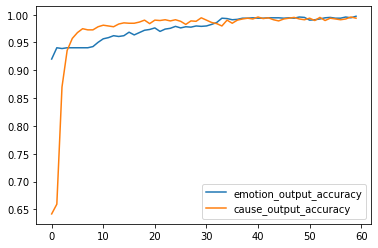

In [60]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

pyplot.plot(history.history['emotion_output_accuracy'],label='emotion_output_accuracy')
pyplot.plot(history.history['cause_output_accuracy'],label='cause_output_accuracy')

pyplot.legend()
pyplot.show()

In [0]:
# save model and architecture to single file
#model.save('model.h5')
#print("Saved model to disk")

In [62]:
#print(X_padded_seq)
#print(clause_global[:30])
#cause_
from collections import defaultdict
# print('causes: ', model.predict({'clause_input': X_padded_seq})[1][0:30])
# print('-----')
# print('emotions: ', model.predict({'clause_input': X_padded_seq})[0][1])

(predicted_emotions, predicted_causes) = model.predict({'clause_input': X_padded_seq})

cause_clauses_per_doc_id = defaultdict(list)
emotion_clauses_per_doc_id = defaultdict(list)
doc_id_to_clause_id_emotions_map = defaultdict(list)
for clause_id, cause_prob in enumerate(predicted_causes):
  if cause_prob > 0.5:
    cause_clauses_per_doc_id[clauseid_to_docid[clause_id]].append(clause_id)

# print('cause_clauses_per_doc_id: ', cause_clauses_per_doc_id)
# print('predicted_emotions[12]: ', predicted_emotions[12])
# print('predicted_emotions[13]: ', predicted_emotions[13])
# print('predicted_emotions[14]: ', predicted_emotions[14])

for clause_id, emotion_prob in enumerate(predicted_emotions):
  max_emotion_prob=0.0
  max_idx=0
  for i, prob in enumerate(emotion_prob):
    if prob>max_emotion_prob:
      max_emotion_prob = prob
      max_idx=i

  #max_emotion=emotion_seeds[max_idx] # wrong because emotion has been tokenized
  max_emotion=tokenized_id_to_emotion_map[max_idx]
  if max_idx!=1: # skip 'xxxxxx' as emotion(unknown)
    emotion_clauses_per_doc_id[clauseid_to_docid[clause_id]].append(max_idx)
  doc_id_to_clause_id_emotions_map[clauseid_to_docid[clause_id]].append(clause_id)

print('emotion_clauses_per_doc_id:', emotion_clauses_per_doc_id)
print('doc_id_to_clause_id_emotions_map:', doc_id_to_clause_id_emotions_map)

emotion_clauses_per_doc_id: defaultdict(<class 'list'>, {0: [2, 4], 1: [2], 2: [2], 3: [2], 4: [2], 5: [2], 6: [2], 7: [2], 8: [2], 9: [2], 10: [2], 11: [2], 12: [2], 14: [2, 2], 15: [2], 16: [2], 17: [2], 18: [2], 19: [2], 20: [2], 21: [2], 22: [2], 23: [2], 24: [2], 25: [2], 30: [2], 42: [6], 71: [3], 128: [4], 151: [2], 211: [3], 212: [3], 213: [3], 214: [3], 215: [3], 216: [3], 217: [3], 218: [3], 219: [3], 220: [3], 221: [3], 222: [3], 223: [3], 224: [3], 225: [3], 226: [3], 227: [3], 228: [3], 229: [3], 230: [3], 231: [3], 232: [3], 233: [3], 299: [6], 307: [6], 308: [6], 323: [6], 332: [7], 383: [2], 408: [6], 409: [4], 410: [7, 6], 411: [6], 412: [6], 413: [6], 414: [6], 415: [6], 416: [6], 417: [4, 6], 418: [6], 419: [6], 420: [6], 421: [6], 422: [6], 423: [6], 424: [6], 425: [6], 426: [6], 458: [6], 474: [6]})
doc_id_to_clause_id_emotions_map: defaultdict(<class 'list'>, {0: [0, 1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9, 10], 4: [11, 12, 13], 5: [14, 15, 16], 6: [17, 18], 7: [

In [63]:
#input : emotion * cause
num_docs=500
emotion_cause_pair_per_doc_id=[]
ec_pair_per_doc_id=[]
for doc_id in range(num_docs):
  causes = cause_clauses_per_doc_id[doc_id]
  emotions = emotion_clauses_per_doc_id[doc_id]
  emotion_clause_ids = doc_id_to_clause_id_emotions_map[doc_id]
  emotion_cause_pair=[]
  ec_pair=[] # ec_pair is (emotion clause id, cause clause id) pairs

  for cause in causes:
    for emotion in emotions:
      if emotion != 1:
        emotion_cause_pair.append((emotion, cause))

  for cause in causes:
    for e in emotion_clause_ids:
        ec_pair.append((e, cause))
      
  emotion_cause_pair_per_doc_id.append(emotion_cause_pair)
  ec_pair_per_doc_id.append(ec_pair)

print('emotion_cause_pair_per_doc_id:', emotion_cause_pair_per_doc_id)
print('fixed_known_emotion_cause_pair_per_doc_id:', fixed_known_emotion_cause_pair_per_doc_id)
print('ec_pair_per_doc_id:', ec_pair_per_doc_id)
print(len(emotion_cause_pair_per_doc_id), len(fixed_known_emotion_cause_pair_per_doc_id), len(ec_pair_per_doc_id))

emotion_cause_pair_per_doc_id: [[(2, 1), (4, 1)], [(2, 4)], [(2, 7)], [(2, 10)], [(2, 13)], [(2, 16)], [(2, 18)], [(2, 21)], [(2, 23)], [(2, 27)], [(2, 29)], [(2, 32)], [(2, 34)], [], [(2, 41), (2, 41)], [(2, 44)], [(2, 46)], [(2, 48)], [(2, 50)], [(2, 56)], [(2, 58)], [(2, 60)], [(2, 62)], [(2, 64)], [(2, 66)], [(2, 70)], [], [], [], [], [(2, 83)], [], [], [], [], [], [], [], [], [], [], [], [(6, 123)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(3, 207)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(4, 390)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], 

In [65]:
logic_model_output = []
for doc_id, emotion_cause_pairs in enumerate(emotion_cause_pair_per_doc_id):
  output_per_doc_id = [] # output_per_doc_id is a list of whether expected emotion_cause_pair matches with predicted pair.
  #print(doc_id, emotion_cause_pairs)
  for pair in emotion_cause_pairs:
    if pair[0] == fixed_known_emotion_cause_pair_per_doc_id[doc_id][0] and pair[1] == fixed_known_emotion_cause_pair_per_doc_id[doc_id][1]:
      output_per_doc_id.append(1)
    else:
      output_per_doc_id.append(0)
  logic_model_output.append(output_per_doc_id)
logic_model_output=np.asarray(logic_model_output)
print('logic_model_output: ', logic_model_output[:100], logic_model_output.shape)

logic_model_output:  [list([1, 0]) list([1]) list([1]) list([1]) list([1]) list([1]) list([1])
 list([1]) list([1]) list([1]) list([1]) list([1]) list([1]) list([])
 list([1, 1]) list([1]) list([1]) list([1]) list([1]) list([1]) list([1])
 list([1]) list([1]) list([1]) list([1]) list([1]) list([]) list([])
 list([]) list([]) list([1]) list([]) list([]) list([]) list([]) list([])
 list([]) list([]) list([]) list([]) list([]) list([]) list([0]) list([])
 list([]) list([]) list([]) list([]) list([]) list([]) list([]) list([])
 list([]) list([]) list([]) list([]) list([]) list([]) list([]) list([])
 list([]) list([]) list([]) list([]) list([]) list([]) list([]) list([])
 list([]) list([]) list([]) list([0]) list([]) list([]) list([]) list([])
 list([]) list([]) list([]) list([]) list([]) list([]) list([]) list([])
 list([]) list([]) list([]) list([]) list([]) list([]) list([]) list([])
 list([]) list([]) list([]) list([]) list([]) list([]) list([]) list([])] (500,)


In [67]:
# creating input vector
filter_model_input_emotions = []
filter_model_input_causes = []
logistic_model_per_clause_output=[]
empty_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] # len 30
for doc_id, pairs in enumerate(ec_pair_per_doc_id): # ec_pair is (emotion clause id, cause clause id) pairs
  if not pairs: # pairs is ec_pair
    filter_model_input_emotions.append(empty_list)
    filter_model_input_causes.append(empty_list)
    logistic_model_per_clause_output.append(1)
  else:
    output_list = logic_model_output[doc_id]
    print(output_list, pairs, doc_id)
    for idx, pair in enumerate(pairs):
      (e, c) = pair # e is emotion_clause_id, c is cause_clause_id
      print(idx, pair, e, c)
      filter_model_input_emotions.append(X_padded_seq[e].tolist())
      filter_model_input_causes.append(X_padded_seq[c].tolist())
      if idx<len(output_list):
        logistic_model_per_clause_output.append(output_list[idx])

filter_model_input_emotions = np.asarray(filter_model_input_emotions)
filter_model_input_causes = np.asarray(filter_model_input_causes)

filter_model_input_emotions = np.array(list(x for x in filter_model_input_emotions))
filter_model_input_causes = np.array(list(x for x in filter_model_input_causes))

logistic_model_per_clause_output=np.array(list(x for x in logistic_model_per_clause_output))

#np.set_printoptions(threshold=1000)
# for i in filter_model_input_emotions:
# print(i, )
print(filter_model_input_emotions[:5], filter_model_input_emotions.shape)
print('-------\n')
print(filter_model_input_causes[0:5], filter_model_input_causes.shape)
print('-------\n')
print(logistic_model_per_clause_output[0:180], type(logistic_model_per_clause_output))

[1, 0] [(0, 1), (1, 1), (2, 1)] 0
0 (0, 1) 0 1
1 (1, 1) 1 1
2 (2, 1) 2 1
[1] [(3, 4), (4, 4)] 1
0 (3, 4) 3 4
1 (4, 4) 4 4
[1] [(5, 7), (6, 7), (7, 7)] 2
0 (5, 7) 5 7
1 (6, 7) 6 7
2 (7, 7) 7 7
[1] [(8, 10), (9, 10), (10, 10)] 3
0 (8, 10) 8 10
1 (9, 10) 9 10
2 (10, 10) 10 10
[1] [(11, 13), (12, 13), (13, 13)] 4
0 (11, 13) 11 13
1 (12, 13) 12 13
2 (13, 13) 13 13
[1] [(14, 16), (15, 16), (16, 16)] 5
0 (14, 16) 14 16
1 (15, 16) 15 16
2 (16, 16) 16 16
[1] [(17, 18), (18, 18)] 6
0 (17, 18) 17 18
1 (18, 18) 18 18
[1] [(19, 21), (20, 21), (21, 21)] 7
0 (19, 21) 19 21
1 (20, 21) 20 21
2 (21, 21) 21 21
[1] [(22, 23), (23, 23), (24, 23)] 8
0 (22, 23) 22 23
1 (23, 23) 23 23
2 (24, 23) 24 23
[1] [(25, 27), (26, 27), (27, 27)] 9
0 (25, 27) 25 27
1 (26, 27) 26 27
2 (27, 27) 27 27
[1] [(28, 29), (29, 29)] 10
0 (28, 29) 28 29
1 (29, 29) 29 29
[1] [(30, 32), (31, 32), (32, 32)] 11
0 (30, 32) 30 32
1 (31, 32) 31 32
2 (32, 32) 32 32
[1] [(33, 34), (34, 34)] 12
0 (33, 34) 33 34
1 (34, 34) 34 34
[] [(35, 38)

In [0]:
print(X_padded_seq.shape)
print(X_padded_seq.shape[1:])
print(y_cause, type(y_cause), y_cause.shape)
print('filter_model_input_emotions.shape: ', filter_model_input_emotions.shape)
print('filter_model_input_causes.shape:', filter_model_input_causes.shape)
print('logistic_model_per_clause_output.shape', logistic_model_per_clause_output.shape)


(1429, 30)
(30,)
[0 1 0 ... 0 0 0] <class 'numpy.ndarray'> (1429,)
filter_model_input_emotions.shape:  (1433, 30)
filter_model_input_causes.shape: (1433, 30)
logistic_model_per_clause_output.shape (1433,)


In [0]:
filter_model_input_emotions = filter_model_input_emotions[:50]
filter_model_input_causes = filter_model_input_causes[:50]
logistic_model_per_clause_output = logistic_model_per_clause_output[:50]

In [0]:
# logistic regresson
input_emotion = keras.layers.Input(shape=X_padded_seq.shape[1:], name='input_emotion')
embedded_emotion_input=keras.layers.Embedding(input_dim=1000, output_dim=1, input_length=30)(input_emotion)
print('embedded_emotion_input.shape: ', embedded_emotion_input.shape)

input_cause = keras.layers.Input(shape=X_padded_seq.shape[1:], name='input_cause')
embedded_cause_input=keras.layers.Embedding(input_dim=1000, output_dim=1, input_length=30)(input_cause)

print('embedded_cause_input.shape: ', embedded_cause_input.shape)
combined = keras.layers.Concatenate()([embedded_cause_input, embedded_emotion_input])

print('combined.shape: ', combined.shape)
output_layer=keras.layers.Dense(1,activation='sigmoid', name='filter_model_output')(combined)

filter_model = keras.Model(inputs=[input_emotion, input_cause], outputs=[output_layer])
filter_model.compile(loss="binary_crossentropy",
              optimizer="sgd", metrics=['accuracy'])

history = filter_model.fit({'input_emotion': filter_model_input_emotions, 'input_cause': filter_model_input_causes},
                           {'filter_model_output': logistic_model_per_clause_output},
                           epochs=50, verbose=1)                         

embedded_emotion_input.shape:  (None, 30, 1)
embedded_cause_input.shape:  (None, 30, 1)
combined.shape:  (None, 30, 2)
Epoch 1/50
45/45 [==============================] - 0s 1ms/step - loss: 0.6587 - accuracy: 0.7930
Epoch 2/50
45/45 [==============================] - 0s 1ms/step - loss: 0.5885 - accuracy: 0.8716
Epoch 3/50
45/45 [==============================] - 0s 1ms/step - loss: 0.5381 - accuracy: 0.8716
Epoch 4/50
45/45 [==============================] - 0s 1ms/step - loss: 0.5013 - accuracy: 0.8716
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: 0.4743 - accuracy: 0.8716
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: 0.4543 - accuracy: 0.8716
Epoch 7/50
45/45 [==============================] - 0s 1ms/step - loss: 0.4393 - accuracy: 0.8716
Epoch 8/50
45/45 [==============================] - 0s 1ms/step - loss: 0.4280 - accuracy: 0.8716
Epoch 9/50
45/45 [==============================] - 0s 1ms/step - loss: 0.4195 - accuracy: 0.8716

In [0]:
# HW: 16th may 2020
1. Fix bugs:
  a. add word indices in the input of logistic regression model
  b. remove empty clause in emotion_cause_pair_per_doc_id/
2. Vocab size is only 1000. May need to increase this to improve the accuracy
3. Create pipeline to prepare data + model training & feeding 
4. Precision/recall/f1 score:
proposed_pairs = (number of correct pairs / number of proposed pairs)  ---> coming out of logistic regression model
5. Use pretrained embeddings like GloVe